# ResOpsAU: attributes from GRanD
***

**Autor:** Chus Casado Rodríguez<br>
**Fecha:** 01-04-2025<br>

**Introduction:**<br>
This code extracts from GRanD the attributes of reservoirs in Australia.

**To be checked:**<br>
* [ ] At the moment I'm not applying the conditions `MIN_AREA` and `MIN_VOL`.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from reservoirs_lshm.utils import DatasetConfig
from reservoirs_lshm.utils.utils import filter_reservoirs

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Configuration

In [2]:
cfg = DatasetConfig('config_dataset.yml')

print(f'Attributes will be saved in {cfg.PATH_ATTRS}')

Attributes will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsAU\v1.0\attributes


## Data

### [BOM](http://www.bom.gov.au/water/) (Australian Bureau of Meteorology)

BOM
-----
No. reservoirs:	120
No. attributes:	3



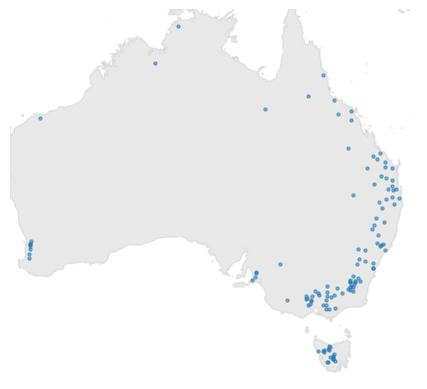

In [4]:
# load TXT used as input for `cutmaps`
bom = pd.read_csv(cfg.PATH_RESOPS / 'ancillary' / 'cutmaps' / 'grand_3min_jupyter.txt', sep='\t', header=None)#.squeeze()
bom.columns = ['lon', 'lat', 'GRAND_ID']
bom.set_index('GRAND_ID', drop=True, inplace=True)
bom = gpd.GeoDataFrame(
    bom,
    geometry=gpd.points_from_xy(bom.lon, bom.lat),
    crs='epsg:4326'
)

print('BOM')
print('-----')
print('No. reservoirs:\t{0}\nNo. attributes:\t{1}\n'.format(*bom.shape))

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
bom.plot(markersize=5, alpha=.5, ax=ax, label='BOM')
ax.axis('off');

### GRanD 

GRanD
-----
No. reservoirs:	190
No. attributes:	58

104 out of 190 reservoirs exceed the minimum catchment area of 250 km2 (0 missing values)
184 out of 190 reservoirs exceed the minimum reservoir volume of 10 hm3 (0 missing values)
101 out of 190 reservoirs exceed the minimum catchment area (250 km2) and the minimum reservoir volume (10 hm3)


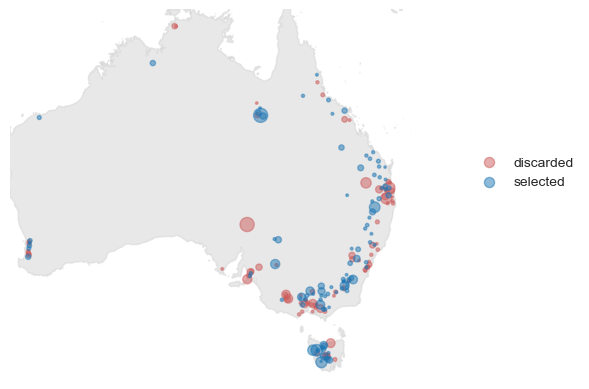

In [5]:
# load shapefile of dams
grand = gpd.read_file(cfg.PATH_GRAND / 'GRanD_dams_v1_3.shp').set_index('GRAND_ID')

# filter dams in the country
grand = grand.loc[grand.COUNTRY.str.lower() == 'australia']

# correct names
grand.DAM_NAME = grand.DAM_NAME.str.upper()
grand.RES_NAME = grand.RES_NAME.str.upper()
grand.ADMIN_UNIT = grand.ADMIN_UNIT.str.upper()

# rename columns
grand.rename(columns={'LON_DD': 'LON', 'LAT_DD': 'LAT'}, inplace=True)
# grand['LON'] = grand.geometry.x
# grand['LAT'] = grand.geometry.y

print('GRanD')
print('-----')
print('No. reservoirs:\t{0}\nNo. attributes:\t{1}\n'.format(*grand.shape))

# select reservoirs based on catchment area and reservoir volume
mask_grand = filter_reservoirs(grand.CATCH_SKM, grand.CAP_MCM, cfg.MIN_AREA, cfg.MIN_VOL)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
grand.loc[~mask_grand].plot(markersize=grand.CAP_MCM**.5, c='indianred', alpha=.5, ax=ax, label='discarded')
grand.loc[mask_grand].plot(markersize=grand.CAP_MCM**.5, alpha=.5, ax=ax, label='selected')
fig.legend(frameon=False, bbox_to_anchor=[1, .4, .1, .2])
ax.axis('off');

# apply the selection
# grand = grand.loc[mask_grand]

### Reservoir use

In [6]:
# rename columns
rename_uses_grand = {'USE_IRRI': 'irrigation',
                     'USE_ELEC': 'hydropower',
                     'USE_SUPP': 'supply',
                     'USE_FCON': 'flood',
                     'USE_RECR': 'recreation',
                     'USE_NAVI': 'navigation',
                     'USE_FISH': 'fish',
                     'USE_PCON': 'pollution',
                     'USE_LIVE': 'livestock',
                     'USE_OTHR': 'other'}
grand.rename(columns=rename_uses_grand, inplace=True)

# replace values in 'MAIN_USE' to be consistent with the columns
grand.MAIN_USE.replace({'Irrigation': 'irrigation',
                        'Hydroelectricity': 'hydropower',
                        'Water supply': 'supply',
                        'Other': 'other',
                        'Recreation': 'recreation',
                        'Flood control': 'flood'},
                       inplace=True)

# convert to boolean
grand_uses = list(rename_uses_grand.values())
grand[grand_uses] = grand[grand_uses].replace({'Main': True, 'Major': True, 'Sec': True, None: False})

# identify single purpose reservoirs
grand['SINGLE_USE'] = False
mask_singleuse = grand[grand_uses].sum(axis=1) == 1
grand.loc[mask_singleuse, 'SINGLE_USE'] = True

**Main use**

In [7]:
mask_singleuse = grand.SINGLE_USE
mask_hdcc = ~grand.index.isnull()

mainuse_singlepurpose = grand.loc[mask_hdcc & mask_singleuse, 'MAIN_USE'].value_counts()
mainuse_multipurpose = grand.loc[mask_hdcc, 'MAIN_USE'].value_counts()
mainuse_summary_grand = pd.concat((mainuse_singlepurpose, mainuse_multipurpose), axis=1)
mainuse_summary_grand.columns = ['singlepurpose', 'multipurpose']
mainuse_summary_grand.sort_values('multipurpose', ascending=False, inplace=True)
del mainuse_singlepurpose, mainuse_multipurpose

**All uses**

In [8]:
alluses_singlepurpose = grand.loc[mask_hdcc & mask_singleuse, grand_uses].sum()
alluses_multipurpose = grand.loc[mask_hdcc, grand_uses].sum()
alluses_summary_grand = pd.concat((alluses_singlepurpose, alluses_multipurpose), axis=1)
alluses_summary_grand.columns = ['singlepurpose', 'multipurpose']
alluses_summary_grand.sort_values('multipurpose', ascending=False, inplace=True)
alluses_summary_grand.dropna(axis=0, how='all', inplace=True)
alluses_summary_grand = alluses_summary_grand[~(alluses_summary_grand == 0).all(axis=1)]
del alluses_singlepurpose, alluses_multipurpose

### Export

In [9]:
# convert boolean fields to 0-1
bool_cols = list(rename_uses_grand.values()) + ['SINGLE_USE']
grand[bool_cols] = grand[bool_cols].astype(bool).astype(int)

# attributes to be included from GRAND
grand.columns = grand.columns.str.upper()
cols_grand = ['DAM_NAME', 'YEAR', 'REM_YEAR',
              'DAM_HGT_M', 'DAM_LEN_M', 'AREA_SKM', 'CAP_MCM', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM',
              'irrigation', 'hydropower', 'supply', 'flood', 'recreation', 'navigation', 'fish', 'pollution', 'livestock', 'other', 'MAIN_USE', 'SINGLE_USE','LAKE_CTRL']
cols_grand = [col.upper() for col in cols_grand]

# export as CSV
grand.loc[bom.index, cols_grand].to_csv(cfg.PATH_ATTRS / 'grand.csv')